In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
from pantarei.fenicsstorage import FenicsStorage

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import PIL

import nibabel

Start with figuring out how to create a snapshot of an image at a desired time. Need to: 

1. Open T1-reference image and imshow the desired slice.
2. Open concentration-data and imshow the desired slice on top of the previous image.
3. Save image into path

# Preliminary Tests

In [4]:
patpath = Path("DATA/PAT_002")
impath = patpath / "IMAGES"
simpath = patpath / "SIMULATION"
refpath = patpath / "mri/T1.mgz"
datapath = Path("DATA/PAT_002/FENICS/cdata_32.hdf")

ref = nibabel.load(refpath)
mask = nibabel.load(patpath / "mri/parenchyma_only.mgz").get_fdata()
mask[mask==0] = np.nan

storage = FenicsStorage(datapath, "r")
t_data = storage.read_timevector("cdata")
print(t_data / 3600)
storage.close()

[ 0.          4.01361111 23.17583333 47.72972222 69.60444444]


In [5]:
hours = np.rint(t_data/3600).astype(int)

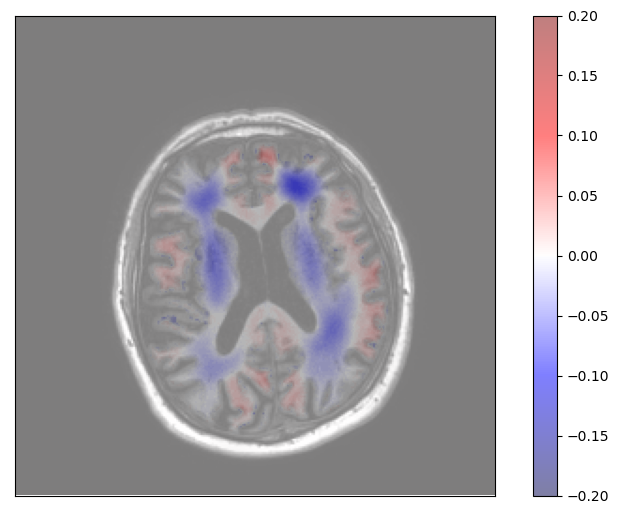

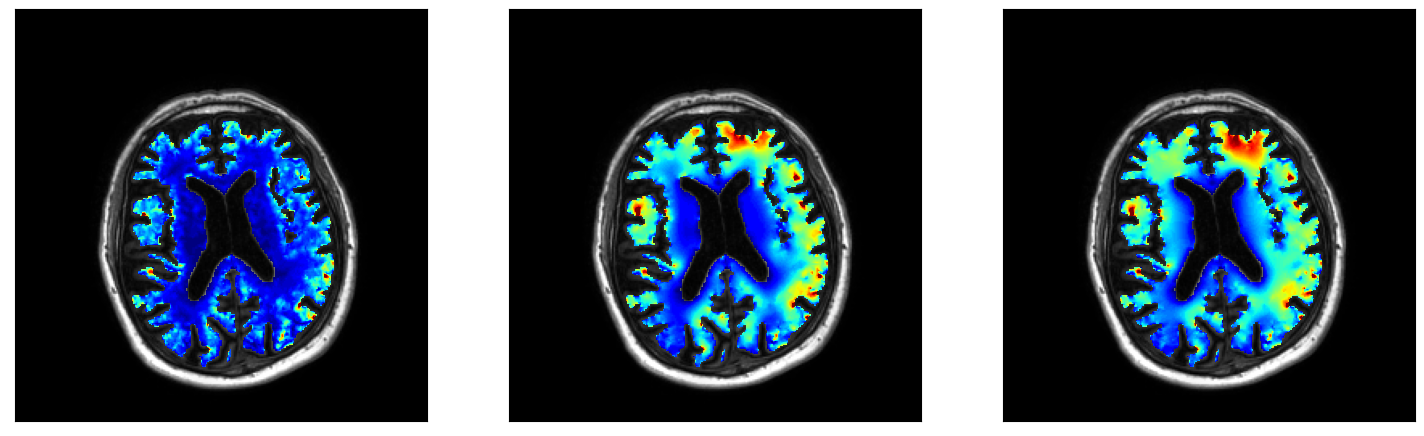

In [6]:
patpath = Path("DATA/PAT_002")
impath = patpath / "IMAGES"
simpath = patpath / "SIMULATION"
refpath = patpath / "mri/T1.mgz"

ref = nibabel.load(refpath)
mask = nibabel.load(patpath / "mri/parenchyma_only.mgz").get_fdata()
mask[mask==0] = np.nan

h = "51"
slice_idx = 101
data = nibabel.load(simpath / f"0{h}.nii.gz")
sim_diffusion = nibabel.load(simpath / f"diffusion_{h}.nii.gz")
sim_multidiff = nibabel.load(simpath / f"multidiffusion_total_{h}.nii.gz")
im_ref = ref.get_fdata()[:, slice_idx, :]


difference = sim_diffusion.get_fdata()[:, slice_idx, :] - sim_multidiff.get_fdata()[:, slice_idx, :]
vabs = max(abs(difference.min()), abs(difference.max()))
vabs = 0.2
plt.figure()
plt.imshow(im_ref.T, cmap="gray", origin="lower")
plt.imshow(difference.T, cmap="seismic", vmin=-vabs, vmax=+vabs, origin="lower", alpha=0.5)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.subplots_adjust(left=-0.1, right=1.1, top=1., bottom=0.)
plt.savefig("test.png", bbox_inches="tight")

fig, axs = plt.subplots(1, 3, figsize=(14, 8))
for ax, nii in zip(axs, [data, sim_diffusion, sim_multidiff]):
    im = nii.get_fdata()[:, slice_idx, :].copy() * mask[:, slice_idx, :]
    ax.imshow(im_ref.T, cmap="gray", origin="lower")
    ax.imshow(im.T, cmap="jet", vmin=0.0, vmax=0.3, origin="lower")
    ax.set_xticks([])
    ax.set_yticks([])
    plt.subplots_adjust(left=0., right=1., top=1., bottom=0.)

plt.show()

# Model Comparison

In [7]:
mask = nibabel.load(patpath / "mri/parenchyma_only.mgz").get_fdata()
mask[mask==0] = np.nan

def load_mri_data(fpath, slice_, mask=None):
    mri = nibabel.load(fpath)
    im = mri.get_fdata()[slice_]
    if mask is not None:
        im *= mask[slice_]
    return im 

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Content Curves

Here the goal is to plot the total mass content in the brain and various brain regions at each of the time-points of the simulation, and compare this curve for different models.

I want to see at least four curves. 
- the total mass as computed from the diffusion model.
- the total mass as computed from the multicompartment-diffusion model.
- the mass within each of the compartments from the multidiffusion-model (two curves).

In [14]:
from pantarei.fenicsstorage import FenicsStorage

import dolfin as df
from tqdm import tqdm

In [15]:
datapath = Path("DATA/PAT_002/FENICS/cdata_32.hdf")

storage = FenicsStorage(datapath, "r")
t_data = storage.read_timevector("cdata")
tvec = storage.read_timevector("diffusion")
print(t_data / 3600)
storage.close()

[ 0.          4.01361111 23.17583333 47.72972222 69.60444444]


In [16]:
molars_to_moles_per_mm3 = 1e-6
phi = [0.14, 0.01]

storage = FenicsStorage(datapath, "r")

tvec = storage.read_timevector("diffusion")
mass_diffusion = np.nan * np.zeros(tvec.size)
mass_ecs = np.nan * np.zeros(tvec.size)
mass_pvs = np.nan * np.zeros(tvec.size)

domain = storage.read_domain()
for idx, ti in tqdm(enumerate(tvec)):
    u = storage.read_function("diffusion", domain, idx)
    mass_diffusion[idx] = df.assemble(u * df.dx) * molars_to_moles_per_mm3
    
    c = storage.read_function("multidiffusion", domain, idx)
    mass_ecs[idx] = phi[0] * df.assemble(c.sub(0) * df.dx) * molars_to_moles_per_mm3
    mass_pvs[idx] = phi[1] * df.assemble(c.sub(1) * df.dx) * molars_to_moles_per_mm3
storage.close()
mass_total = mass_ecs + mass_pvs
mass_total

71it [04:53,  4.13s/it]


array([0.        , 0.00479778, 0.01145497, 0.01941402, 0.02834427,
       0.03452427, 0.0399361 , 0.04488645, 0.04952727, 0.05394862,
       0.05820844, 0.06234562, 0.06638743, 0.0703536 , 0.0742588 ,
       0.07811416, 0.08192829, 0.08570795, 0.08945854, 0.09318439,
       0.09688906, 0.10057545, 0.10424599, 0.10790269, 0.10979181,
       0.11057885, 0.11071346, 0.11037982, 0.10969441, 0.10873568,
       0.1075589 , 0.10620446, 0.10470272, 0.10307708, 0.10134594,
       0.09952407, 0.09762345, 0.09565398, 0.09362391, 0.09154021,
       0.08940878, 0.08723472, 0.08502241, 0.08277565, 0.08049779,
       0.07819175, 0.07586011, 0.07350518, 0.07131253, 0.06966847,
       0.06825267, 0.06699316, 0.06584727, 0.06478737, 0.06379445,
       0.06285491, 0.0619587 , 0.06109818, 0.06026741, 0.05946172,
       0.05867736, 0.05791128, 0.05716099, 0.0564244 , 0.05569979,
       0.05498568, 0.05428083, 0.05358419, 0.05289483, 0.05221198,
       0.05161681])

In [17]:
storage = FenicsStorage(datapath, "r")
t_data = storage.read_timevector("cdata")
mass_data = np.nan * np.zeros(t_data.size)
for idx, ti in enumerate(t_data):
    data = storage.read_function("cdata", domain, idx)
    mass_data[idx] = df.assemble(data * df.dx) * molars_to_moles_per_mm3
storage.close()

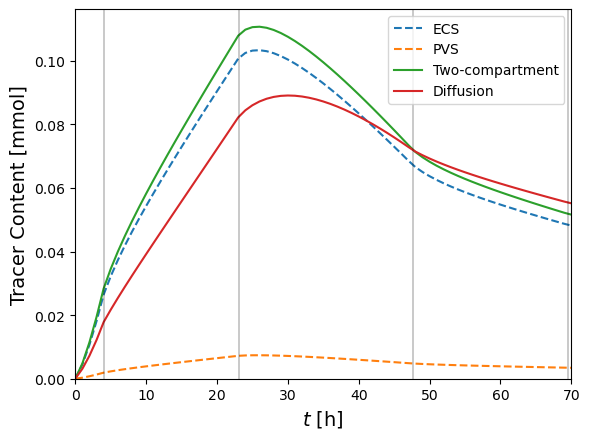

In [32]:
plt.figure()
plt.plot(tvec, mass_ecs, '--', label="ECS")
plt.plot(tvec, mass_pvs, '--', label="PVS")
plt.plot(tvec, mass_total, label='Two-compartment')
plt.plot(tvec, mass_diffusion, label="Diffusion")
# plt.plot(t_data, mass_data, "o-k", label="data")
plt.xticks(tvec[::10], (tvec[::10] / 3600).astype(int))
plt.xlabel(r"$t$ [h]", fontsize=14)
plt.ylabel(r"Tracer Content [mmol]", fontsize=14)
plt.ylim(0, None)
plt.xlim(tvec[0], tvec[-1])
for ti in t_data:
    plt.axvline(ti, color="k", ls="-", lw=0.3)
plt.legend()
plt.savefig("concentration-curves.png", bbox_inches='tight')
plt.show()

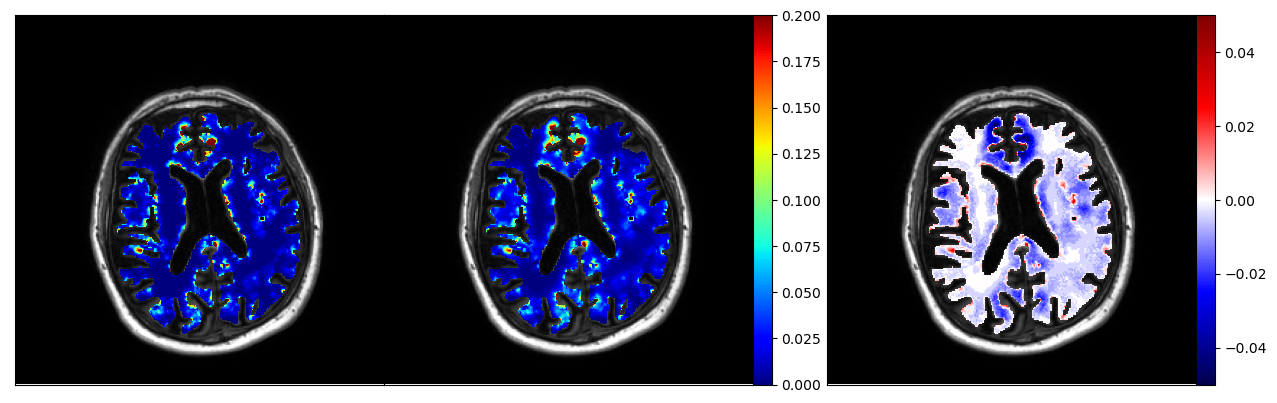

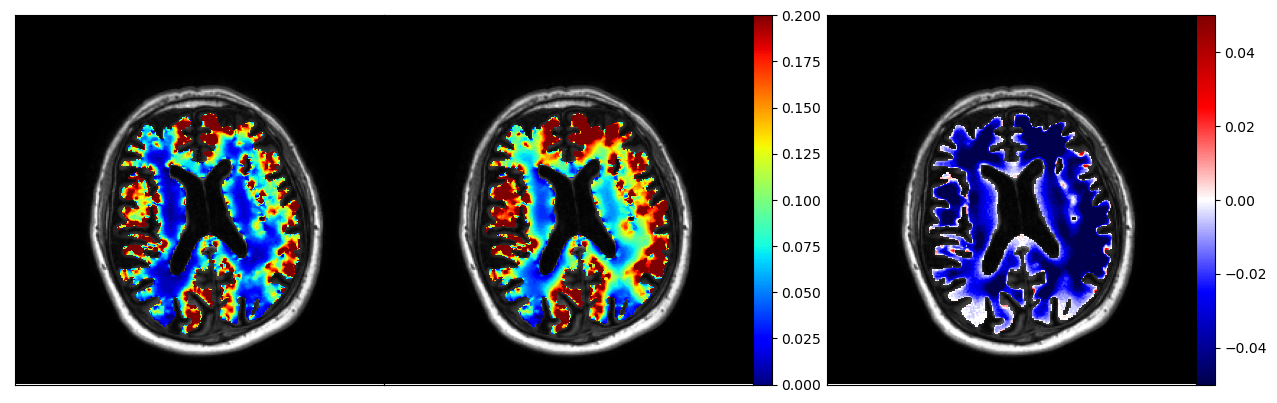

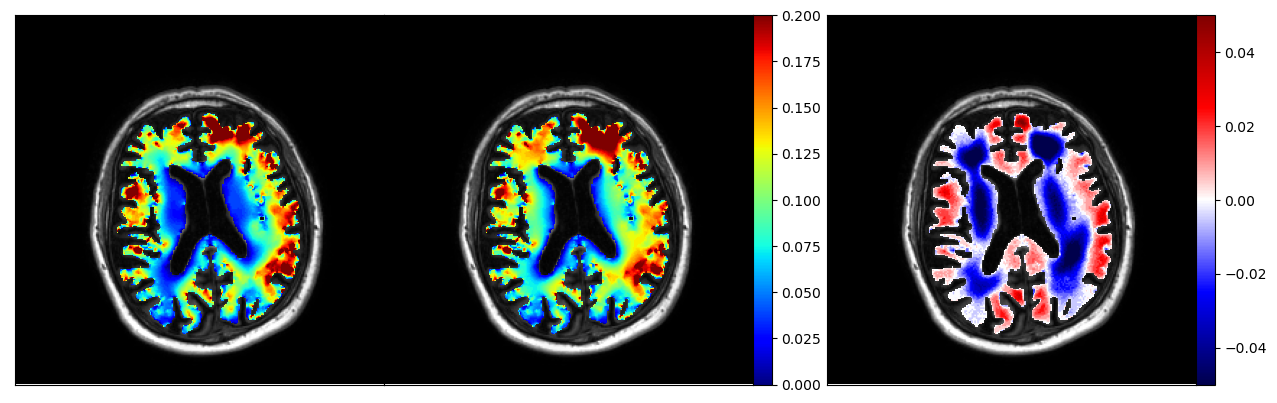

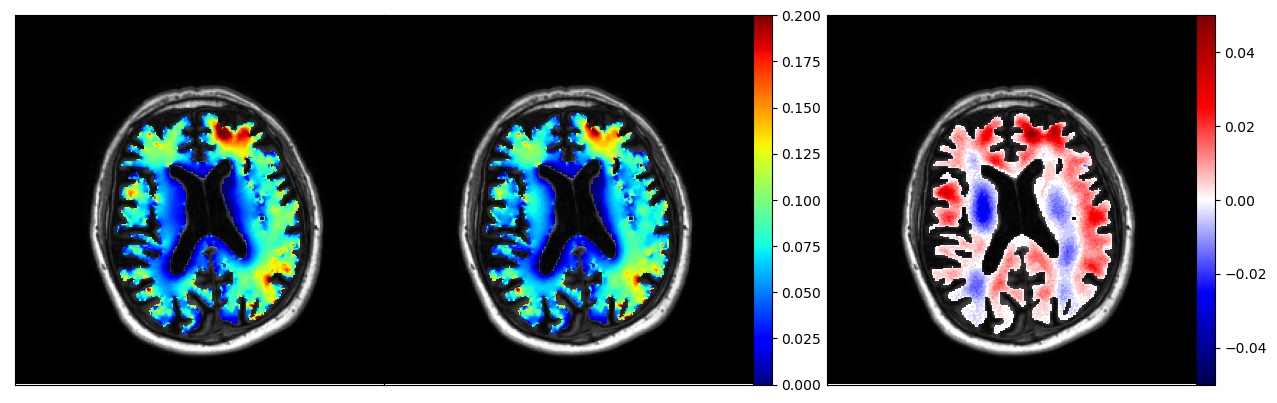

In [207]:
W, H = im_diffusion.shape
d = 0.05 * W
gap = 0.15 * W
header = 0.1 * H
total_length = (3 * W + 2 * d + gap)

fig_width = 12
scale_factor = fig_width / total_length
fig_height = scale_factor * H

cbar_labelsize=10

def plot_comparison_row(im_ref, image1, image2, image3, diffmax, vrange, title=False):
    vmin, vmax = vrange
    fig = plt.figure(figsize=(fig_width, fig_height))
    ax1 = fig.add_axes([0.0, 0.0, W / total_length, 1])
    ax1.imshow(im_ref.T, origin="lower", cmap="gray")
    c1 = ax1.imshow(image1.T, origin="lower", vmin=vmin, vmax=vmax, cmap="jet")
    ax1.set_xticks([])
    ax1.set_yticks([])


    ax2 = fig.add_axes([W / total_length, 0.0, W / total_length, 1])
    ax2.imshow(im_ref.T, origin="lower", cmap="gray")
    ax2.imshow(image2.T, origin="lower", vmin=vmin, vmax=vmax, cmap="jet")
    ax2.set_xticks([])
    ax2.set_yticks([])

    cax1 = fig.add_axes([2 * W / total_length, 0.0, d / total_length, 1])
    plt.colorbar(c1, cax=cax1)
    cax1.tick_params(labelsize=cbar_labelsize)

    ax3 = fig.add_axes([(2*W+gap+d)/ total_length, 0.0, W / total_length, 1])
    ax3.imshow(im_ref.T, origin="lower", cmap="gray")
    c2 = ax3.imshow(image3.T, cmap="seismic", vmin=-diffmax, vmax=diffmax, origin="lower")
    ax3.set_xticks([])
    ax3.set_yticks([])

    cax2 = fig.add_axes([(3*W+gap+d)/ total_length, 0.0, d / total_length, 1])
    plt.colorbar(c2, cax=cax2)
    cax2.tick_params(labelsize=cbar_labelsize)
    
    if title:
        titles = ["Diffusion", "Multicompartment\nDiffusion", "Diffusion - Multicompartment"]
        for ax, title in zip([ax1, ax2, ax3], titles):
            ax.set_title(title, fontsize=16)
    
    return fig

hours = ["07", "26", "51", "73"]

for idx, h in enumerate(hours):
    im_diffusion = load_mri_data(simpath / f"diffusion_{h}.nii.gz", slice_, mask)
    im_multidiff = load_mri_data(simpath / f"multidiffusion_total_{h}.nii.gz", slice_, mask)
    difference = im_diffusion - im_multidiff
    
    fig = plot_comparison_row(im_ref, im_diffusion, im_multidiff, difference, 0.05, (0, 0.2))#, title=(idx==0))
    plt.savefig(f"figures/model-comparison{h}.png", bbox_inches="tight")
    plt.show()

In [208]:
W, H = im_diffusion.shape
d = 0.05 * W
gap = 0.15 * W
header = 0.18 * H
total_length = (3 * W + 2 * d + gap)

fig_width = 12
scale_factor = fig_width / total_length
fig_height = scale_factor * H

stacked_height = (4 * W + header)

text_args = dict(
    fontsize=18,
    verticalalignment="center",
    horizontalalignment="center"
)

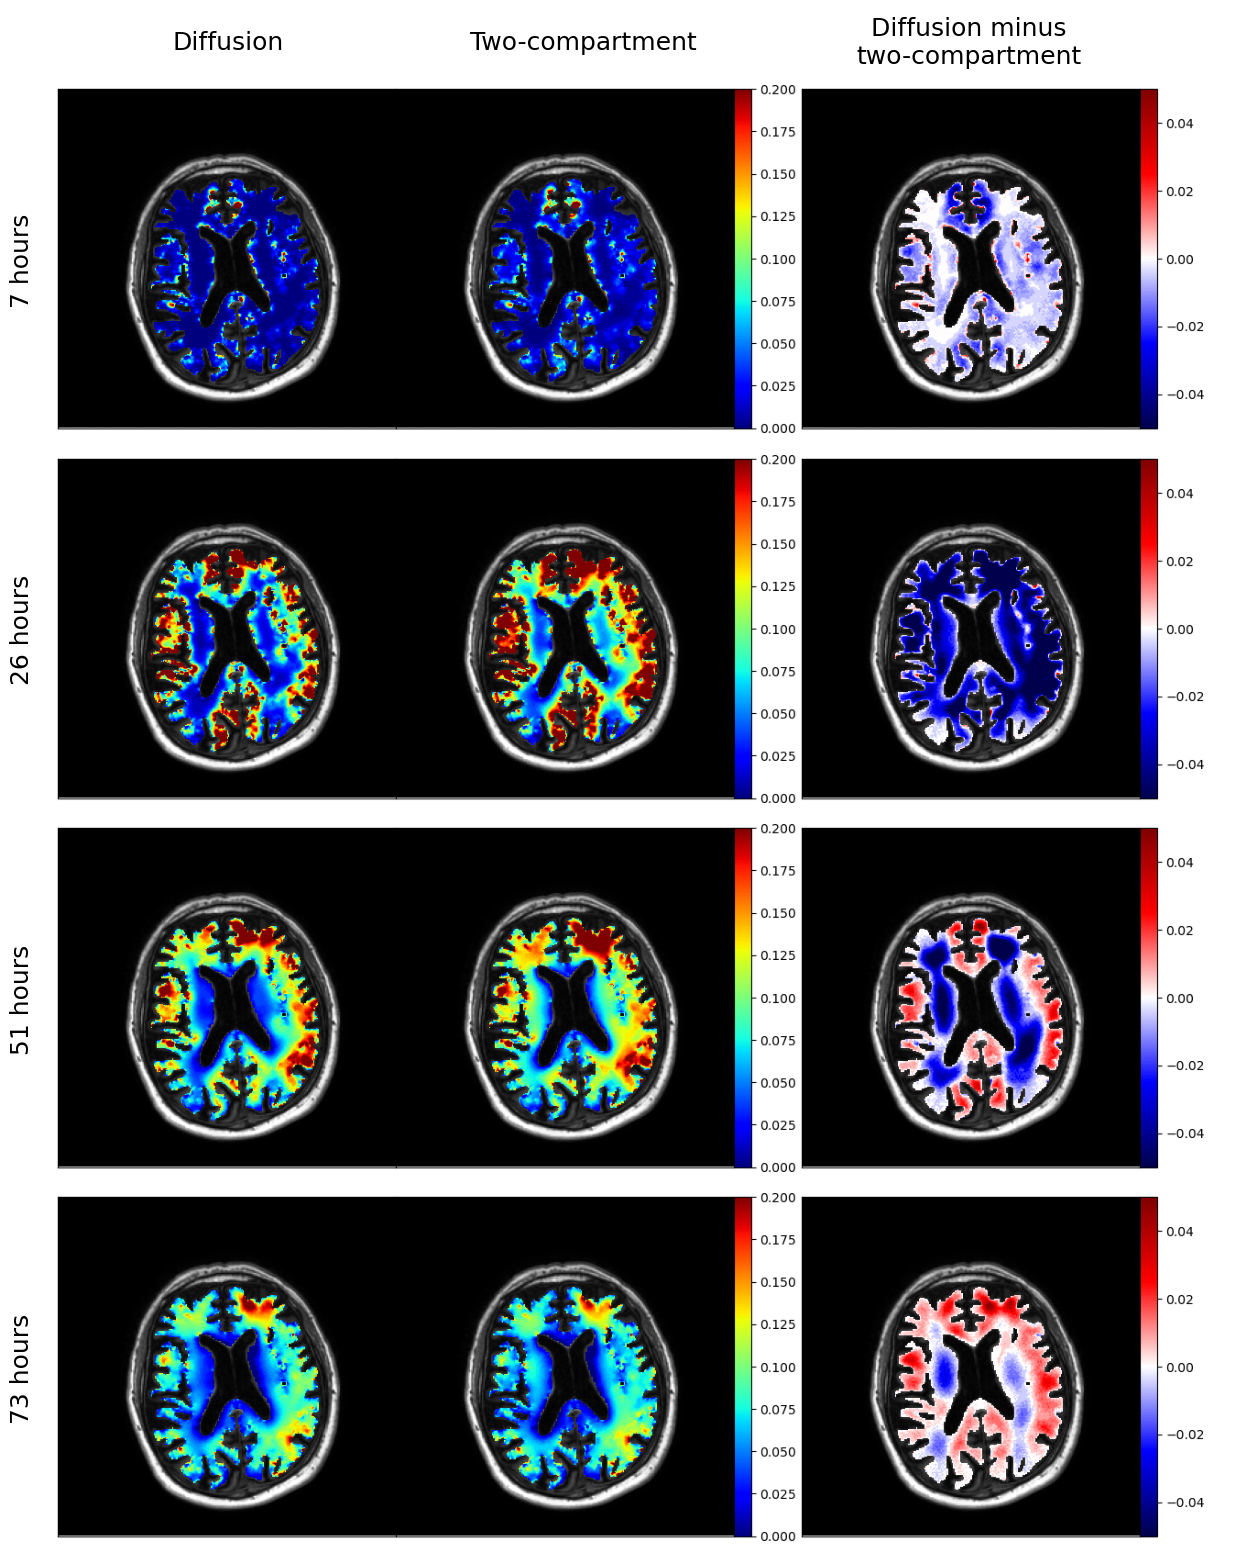

In [210]:
fig = plt.figure(figsize=(fig_width, scale_factor * stacked_height))

downscale = 1.0
offset = downscale * W / 2
offset_vert = 0.5
hax = fig.add_axes([0, 1-(header/stacked_height), 1, header / stacked_height])
hax.axis("off")
hax.text((offset + 10) / total_length, offset_vert, "Diffusion", **text_args)
hax.text((offset +  W) / total_length, offset_vert, "Two-compartment", **text_args)
hax.text((offset + 2 * W + d + gap - 40) / total_length, offset_vert, "Diffusion minus\ntwo-compartment", **text_args)


for idx, h in enumerate(hours):
    im = PIL.Image.open(f"figures/model-comparison{h}.png")
    ax = fig.add_axes([0, 1 - (header + (idx + 1)* H) / stacked_height, 1.0,  H / stacked_height])
    ax.imshow(im)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel(f"{int(h)} hours", fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
plt.savefig("figures/model-comparison.png", bbox_inches="tight")

In [ ]:
data = load_mri_data(simpath / f"0{h}.nii.gz", slice_, mask)
im_diffusion = load_mri_data(simpath / f"diffusion_{h}.nii.gz", slice_, mask)
im_multidiff = load_mri_data(simpath / f"multidiffusion_total_{h}.nii.gz", slice_, mask)
difference = im_diffusion - im_multidiff

In [171]:
W, H = im_diffusion.shape
d = 0.05 * W

fig_width=12
scale_factor = fig_width / (3 * W + 2 * d)
fig_height = scale_factor * H